<a href="https://colab.research.google.com/github/SurajDeSilva/PINNs-For-Non-Linear-Odes/blob/main/Non_Homoegenus_Inverse_and_forward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Genarate Trainig Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp

# External forcing function (e.g., sinusoidal)
def forcing_function(t, A=1.0, omega=1.5):
    return A * np.sin(omega * t)

# Non-homogeneous damped harmonic oscillator system
def nonhomogeneous_dho(t, y, m, mu, k, A, omega):
    x, v = y
    dxdt = v
    dvdt = (1/m) * (forcing_function(t, A, omega) - mu*v - k*x)
    return [dxdt, dvdt]

# Parameters
m = 2.0       # Mass (kg)
mu = 0.3      # Damping coefficient
k = 0.2       # Spring constant
A = 1.0       # Amplitude of forcing function
omega = 1.5   # Frequency of forcing function

# Initial conditions: [x(0), v(0)]
y0 = [1.0, 0.0]

# Time domain
t_train_eval = np.linspace(0, 30, 80)

# Solve the ODE system
solution_train = solve_ivp(
    nonhomogeneous_dho,
    (0, 30),
    y0,
    args=(m, mu, k, A, omega),
    t_eval=t_train_eval,
    method='RK45'
)

# Create the training DataFrame
train_df = pd.DataFrame({
    'Time': solution_train.t,
    'Displacement': solution_train.y[0],
    'Velocity': solution_train.y[1]
})

print(train_df.shape)
print(train_df.head())

(80, 3)
       Time  Displacement  Velocity
0  0.000000      1.000000  0.000000
1  0.379747      0.999562  0.014763
2  0.759494      1.022067  0.114378
3  1.139241      1.091355  0.250107
4  1.518987      1.208338  0.359133


## Genarate Tesing Data

In [5]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

def forcing_function(t, A=1.0, omega=1.5):
    return A * np.sin(omega * t)

def nonhomogeneous_dho(t, y, m, mu, k, A, omega):
    x, v = y
    dxdt = v
    dvdt = (1/m) * (forcing_function(t, A, omega) - mu*v - k*x)
    return [dxdt, dvdt]

# Physical and forcing parameters
m = 2.0
mu = 0.3
k = 0.2
A = 1.0
omega = 1.5

# Initial conditions
y0 = [1.0, 0.0]

# Define new time range for test set
t_test_eval = np.linspace(0, 60, 120)

# Solve the ODE for test data
solution_test = solve_ivp(
    nonhomogeneous_dho,
    (0, 60),
    y0,
    args=(m, mu, k, A, omega),
    t_eval=t_test_eval,
    method='RK45'
)

# Construct the test DataFrame
test_df = pd.DataFrame({
    'Time': solution_test.t,
    'Displacement': solution_test.y[0],
    'Velocity': solution_test.y[1]
})

print(test_df.shape)
print(test_df.head())


(120, 3)
       Time  Displacement  Velocity
0  0.000000      1.000000  0.000000
1  0.504202      1.002899  0.040025
2  1.008403      1.061607  0.203107
3  1.512605      1.206061  0.357830
4  2.016807      1.399422  0.379791


##Plot Training and Testing data

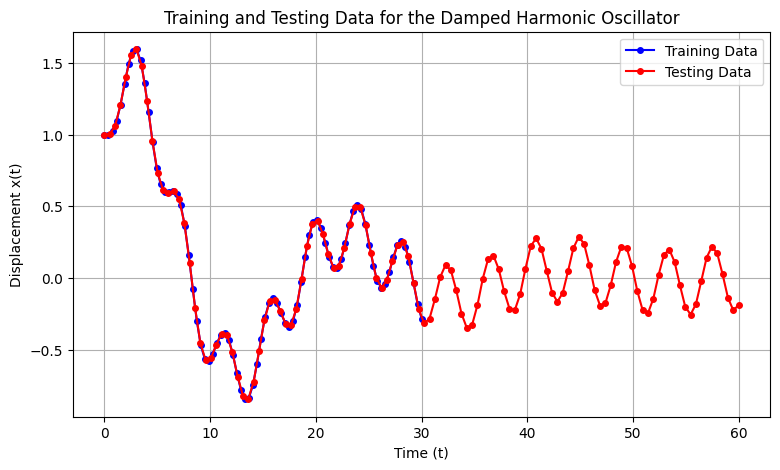

In [9]:
plt.figure(figsize=(9,5))
plt.plot(train_df['Time'], train_df['Displacement'], 'bo-', label='Training Data', markersize=4)
plt.plot(test_df['Time'], test_df['Displacement'], 'ro-', label='Testing Data', markersize=4)
plt.xlabel('Time (t)')
plt.ylabel('Displacement x(t)')
plt.title('Training and Testing Data for the Damped Harmonic Oscillator')
plt.legend()
plt.grid()
plt.show()

## Foward Solution

Epoch 0: Loss = 133.781158, Learning Rate = 0.001000
Epoch 1000: Loss = 0.009765, Learning Rate = 0.000500
Epoch 2000: Loss = 0.001607, Learning Rate = 0.000250
Epoch 3000: Loss = 0.000020, Learning Rate = 0.000063
Epoch 4000: Loss = 0.000020, Learning Rate = 0.000063
Epoch 5000: Loss = 0.000014, Learning Rate = 0.000031
Epoch 6000: Loss = 0.000013, Learning Rate = 0.000031
Epoch 7000: Loss = 0.000020, Learning Rate = 0.000031
Epoch 8000: Loss = 0.000013, Learning Rate = 0.000031
Epoch 9000: Loss = 0.000009, Learning Rate = 0.000016
Epoch 10000: Loss = 0.000008, Learning Rate = 0.000016
Epoch 11000: Loss = 0.000008, Learning Rate = 0.000016
Epoch 12000: Loss = 0.000010, Learning Rate = 0.000016
Epoch 13000: Loss = 0.000010, Learning Rate = 0.000016
Epoch 14000: Loss = 0.000006, Learning Rate = 0.000016
Epoch 15000: Loss = 0.000005, Learning Rate = 0.000008
Epoch 16000: Loss = 0.000005, Learning Rate = 0.000008
Epoch 17000: Loss = 0.000005, Learning Rate = 0.000008
Epoch 18000: Loss = 0

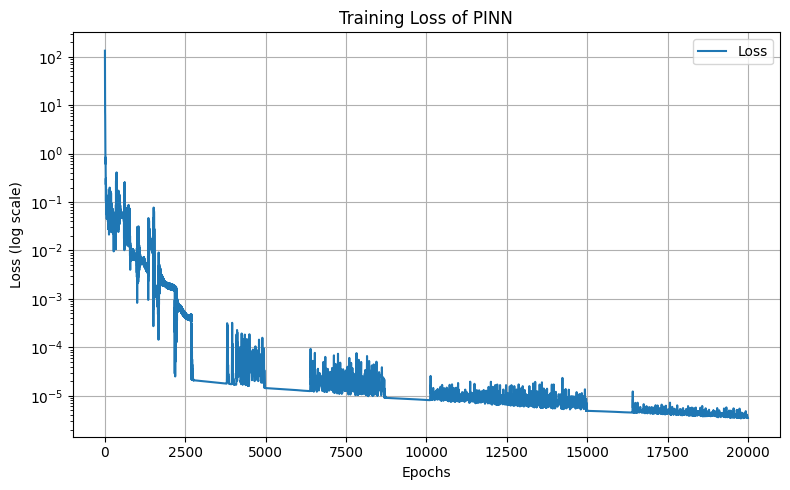

In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


# 2. Convert data to PyTorch tensors


t_train_tensor = torch.tensor(train_df['Time'].values, dtype=torch.float32).view(-1, 1)
x_train_tensor = torch.tensor(train_df['Displacement'].values, dtype=torch.float32).view(-1, 1)

# 3. Define the SIREN-based PINN model


class Sine(nn.Module):
    def forward(self, input):
        return torch.sin(input)

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(1, 128),
            Sine(),
            nn.Linear(128, 128),
            Sine(),
            nn.Linear(128, 128),
            Sine(),
            nn.Linear(128, 1)
        )
        self.apply(self.init_weights)

    def forward(self, t):
        return self.hidden(t)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.uniform_(m.weight, -np.sqrt(6 / m.in_features), np.sqrt(6 / m.in_features))


# 4. Define Loss Functions


# Forcing function in PyTorch
def forcing_function(t, A=1.0, omega=1.5):
    return A * torch.sin(omega * t)

# Physics-Informed Loss (non-homogeneous case)
def physics_loss(model, t):
    t = t.requires_grad_(True)
    x = model(t)
    dx_dt = torch.autograd.grad(x, t, torch.ones_like(x), create_graph=True)[0]
    d2x_dt2 = torch.autograd.grad(dx_dt, t, torch.ones_like(dx_dt), create_graph=True)[0]

    m = 2.0
    mu = 0.3
    k = 0.2
    A = 1.0
    omega = 1.5

    f = m * d2x_dt2 + mu * dx_dt + k * x - forcing_function(t, A, omega)
    return torch.mean(f**2)


def data_loss(model, t, x_true):
    x_pred = model(t)
    return torch.mean((x_pred - x_true) ** 2)


# 5. Training Configuration


model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500, min_lr=1e-6)


# 6. Training Loop


num_epochs = 20000
loss_history = []

for epoch in range(num_epochs):
    optimizer.zero_grad()

    loss_pde = physics_loss(model, t_train_tensor)
    loss_data = data_loss(model, t_train_tensor, x_train_tensor)

    loss = 0.1 * loss_data + 1.0 * loss_pde  # Weighted sum of losses

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step(loss)

    loss_history.append(loss.item())

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}, Learning Rate = {optimizer.param_groups[0]['lr']:.6f}")


# 7. Plot Training Loss


plt.figure(figsize=(8, 5))
plt.plot(loss_history, label='Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.title('Training Loss of PINN')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Forward Solution In range and outside range tesing

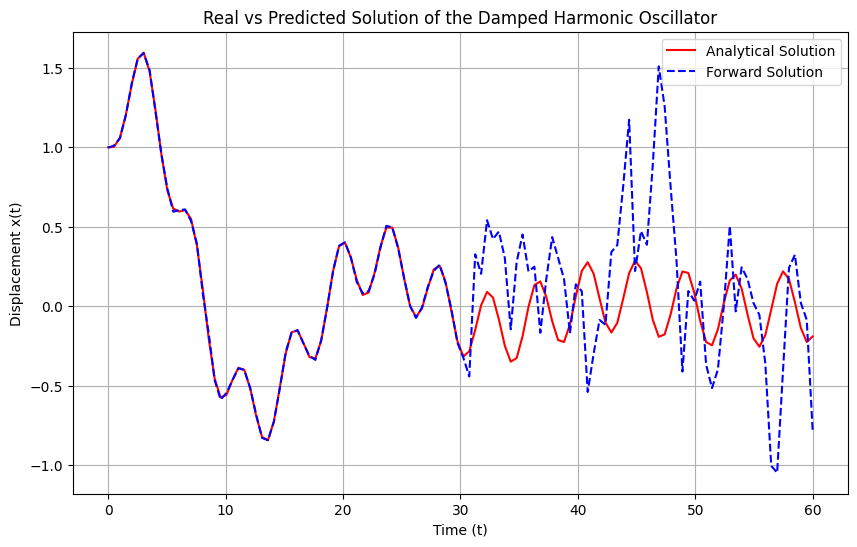

In [13]:
t_test_tensor = torch.tensor(test_df['Time'].values, dtype=torch.float32).view(-1, 1)

# Evaluate the trained model on the test data
x_pred = model(t_test_tensor).detach().numpy()
test_df['PINN_Solution_Predicted_Displacement'] = x_pred

# Plot real vs predicted
plt.figure(figsize=(10, 6))
plt.plot(test_df['Time'], test_df['Displacement'], label='Analytical Solution', color='red')
plt.plot(test_df['Time'], x_pred, label='Forward Solution', color='blue', linestyle='dashed')
plt.xlabel('Time (t)')
plt.ylabel('Displacement x(t)')
plt.title('Real vs Predicted Solution of the Damped Harmonic Oscillator')
plt.legend()
plt.grid()
plt.show()

##Inverse Solution

In [14]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 16.6 MB/s eta 0:00:00


In [17]:
import torch
import torch.nn as nn
import optuna
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Neural Network
class NN(nn.Module):
    def __init__(self, n_input, n_output, n_hidden, n_layers):
        super().__init__()
        self.encode = nn.Sequential(nn.Linear(n_input, n_hidden), nn.Tanh())
        self.hidden = nn.Sequential(*[nn.Sequential(nn.Linear(n_hidden, n_hidden), nn.Tanh()) for _ in range(n_layers - 1)])
        self.decode = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = self.encode(x)
        x = self.hidden(x)
        x = self.decode(x)
        return x

# Plot predictions
def plot_predictions(i, t, x, xh, estimated_params, loss):
    title_params = ", ".join([f"{key}={val:.5f}" for key, val in estimated_params.items()])
    plt.figure(figsize=(6, 4))
    plt.plot(t.detach().numpy(), x.detach().numpy(), "o-", label="Exact X", color="steelblue", markersize=4)
    plt.plot(t.detach().numpy(), xh.detach().numpy(), "o--", label="Predicted X", color="darkorange", markersize=4)
    plt.title(f"Predictions at Step {i}\n{title_params}, Loss={loss:.5f}")
    plt.xlabel("Time (t)")
    plt.ylabel("Displacement (X)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot loss curves
def plot_losses(losses, steps, loss_type="Loss"):
    plt.figure(figsize=(6, 4))
    plt.plot(steps, losses, "b-", label=loss_type)
    plt.title(f"{loss_type} over Training Steps")
    plt.xlabel("Training Steps")
    plt.ylabel(loss_type)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

# PINN training function
def pinn_training(t, x, fixed_params, n_hidden, n_layers, epochs, lambda1, learning_rate, plot=False):
    torch.manual_seed(123)
    model = NN(n_input=1, n_output=1, n_hidden=n_hidden, n_layers=n_layers)

    # Initialize parameter dictionary
    trainable_params = {}
    for param in ['m', 'mu', 'k', 'omega', 'A']:
        if param in fixed_params:
            trainable_params[param] = torch.tensor(fixed_params[param], dtype=torch.float32, requires_grad=False)
        else:
            log_init = torch.tensor(np.log(torch.rand(1).item() + 0.1), dtype=torch.float32, requires_grad=True)
            trainable_params[param] = nn.Parameter(log_init)

    parameters = list(model.parameters()) + [p for p in trainable_params.values() if isinstance(p, nn.Parameter)]
    optimizer = torch.optim.Adam(parameters, lr=learning_rate)

    t_physics = torch.linspace(t.min().item(), t.max().item(), steps=5000, dtype=torch.float32).view(-1, 1).requires_grad_(True)

    data_losses, physics_losses, total_losses, steps = [], [], [], []

    for i in range(epochs + 1):
        optimizer.zero_grad()

        # Data loss
        xh = model(t)
        data_loss = torch.mean((xh - x) ** 2)

        # Physics loss
        xhp = model(t_physics)
        dxdt = torch.autograd.grad(xhp, t_physics, torch.ones_like(xhp), create_graph=True)[0]
        d2xdt2 = torch.autograd.grad(dxdt, t_physics, torch.ones_like(dxdt), create_graph=True)[0]

        # Extract parameter values
        m_val = trainable_params['m'] if not isinstance(trainable_params['m'], nn.Parameter) else torch.exp(trainable_params['m'])
        mu_val = torch.exp(trainable_params['mu']) if isinstance(trainable_params['mu'], nn.Parameter) else trainable_params['mu']
        k_val = torch.exp(trainable_params['k']) if isinstance(trainable_params['k'], nn.Parameter) else trainable_params['k']
        omega_val = torch.exp(trainable_params['omega']) if isinstance(trainable_params['omega'], nn.Parameter) else trainable_params['omega']
        A_val = torch.exp(trainable_params['A']) if isinstance(trainable_params['A'], nn.Parameter) else trainable_params['A']

        forcing = A_val * torch.sin(omega_val * t_physics)
        residual = m_val * d2xdt2.flatten() + mu_val * dxdt.flatten() + k_val * xhp.flatten() - forcing.flatten()
        physics_loss = torch.mean(residual**2)

        loss = data_loss + lambda1 * physics_loss
        loss.backward()
        optimizer.step()

        if i % 10 == 0 or i == epochs:
            data_losses.append(data_loss.item())
            physics_losses.append(physics_loss.item())
            total_losses.append(loss.item())
            steps.append(i)

        if plot and (i % 100 == 0 or i == epochs):
            xh = model(t).detach()
            estimated_values = {
                k: (torch.exp(v).item() if isinstance(v, nn.Parameter) else v.item())
                for k, v in trainable_params.items() if isinstance(v, (torch.Tensor, nn.Parameter)) and v.requires_grad
            }
            plot_predictions(i, t, x, xh, estimated_values, loss.item())

    if plot:
        plot_losses(data_losses, steps, "Data Loss")
        plot_losses(physics_losses, steps, "Physics Loss")
        plot_losses(total_losses, steps, "Total Loss")

    final_estimates = {
        k: (torch.exp(v).item() if isinstance(v, nn.Parameter) else v.item())
        for k, v in trainable_params.items() if isinstance(v, (torch.Tensor, nn.Parameter)) and v.requires_grad
    }

    return loss.item(), final_estimates

# Optuna objective function
def objective(trial):
    n_hidden = trial.suggest_int("n_hidden", 4, 32)
    n_layers = trial.suggest_int("n_layers", 1, 5)
    lambda1 = trial.suggest_loguniform("lambda1", 1e-4, 1e-1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)

    final_loss, _ = pinn_training(t, x, fixed_params, n_hidden=n_hidden, n_layers=n_layers, epochs=500, lambda1=lambda1, learning_rate=learning_rate, plot=False)
    return final_loss

# === Load and Prepare Training Data ===
df = train_df[["Time", "Displacement"]]
t = torch.tensor(df["Time"].values, dtype=torch.float32).view(-1, 1)
x = torch.tensor(df["Displacement"].values, dtype=torch.float32).view(-1, 1)

# === Fix m and A ===
fixed_params = {"m": 2.0, "A": 1.0,"omega": 1.5}

In [ ]:

# === Optuna Hyperparameter Search ===
print("🔍 Finding best hyperparameters...")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

best_params = study.best_params
print(f"✅ Best Hyperparameters: {best_params}")

In [18]:
best_params={'n_hidden': 15, 'n_layers': 5, 'lambda1': 0.0005012449733115869, 'learning_rate': 0.009086464060564316}

📈 Training final model with best parameters and plotting results...


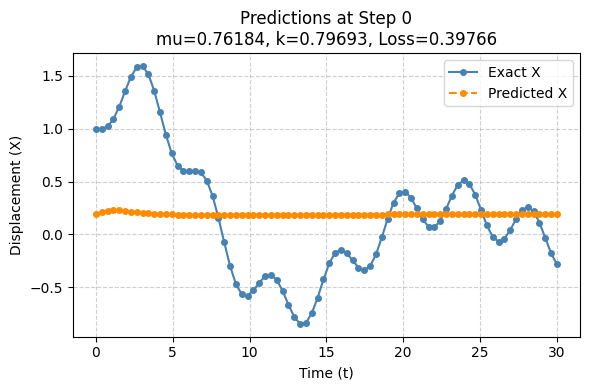

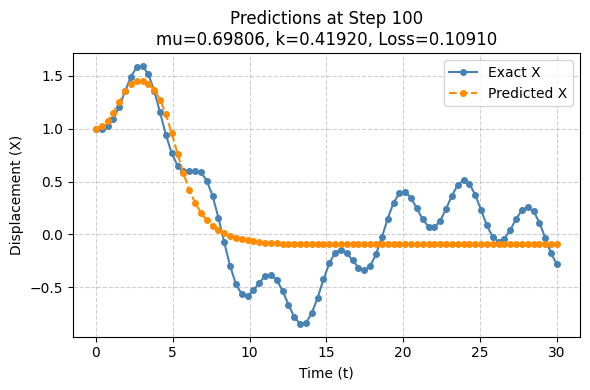

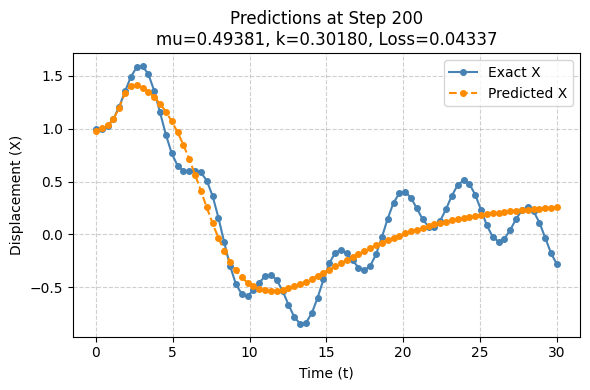

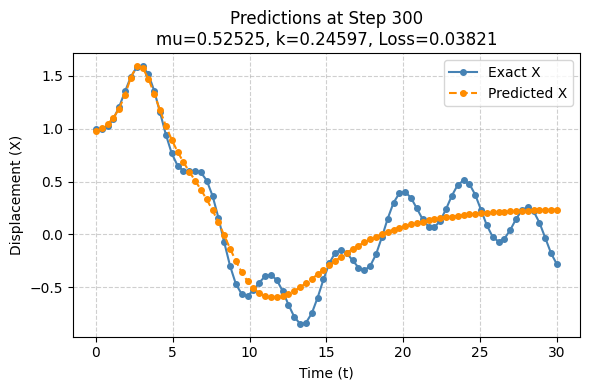

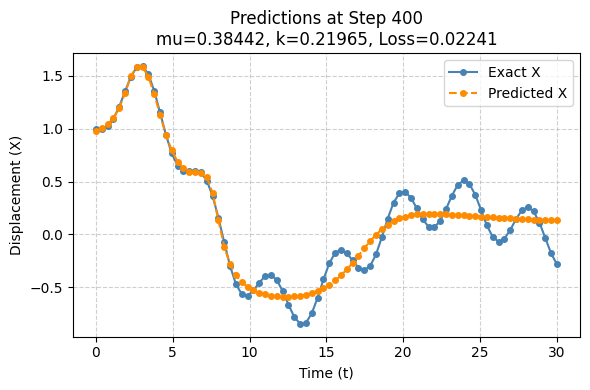

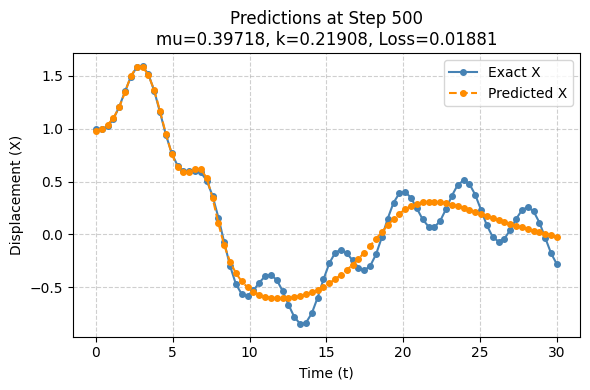

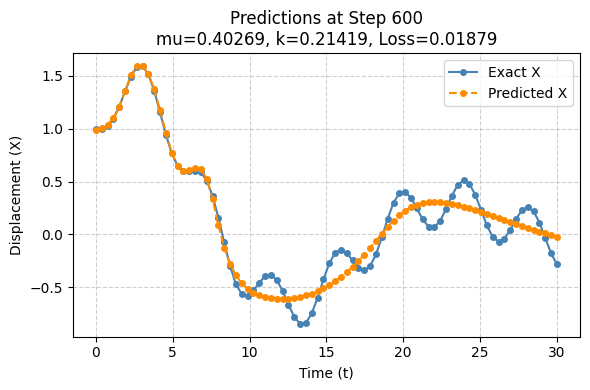

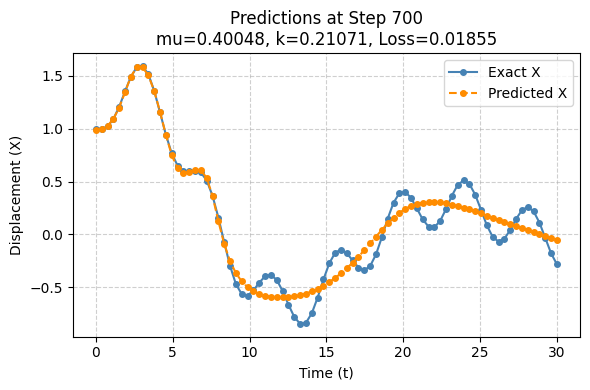

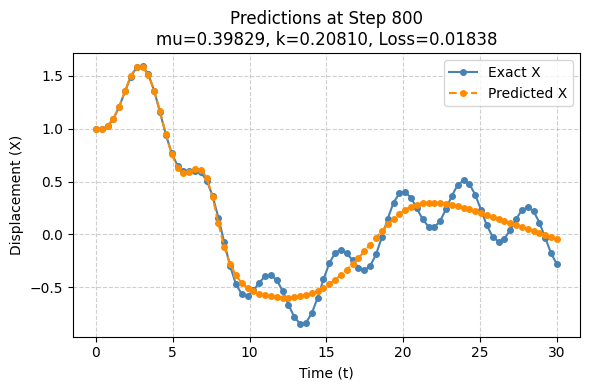

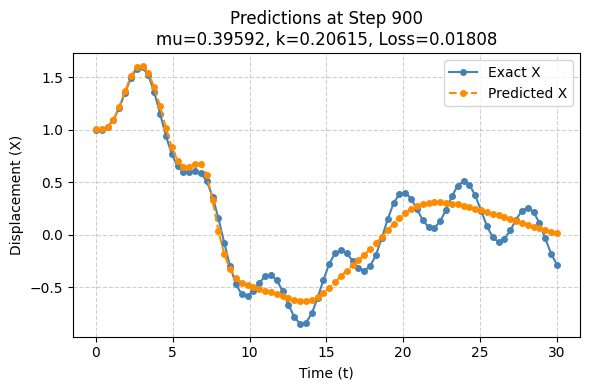

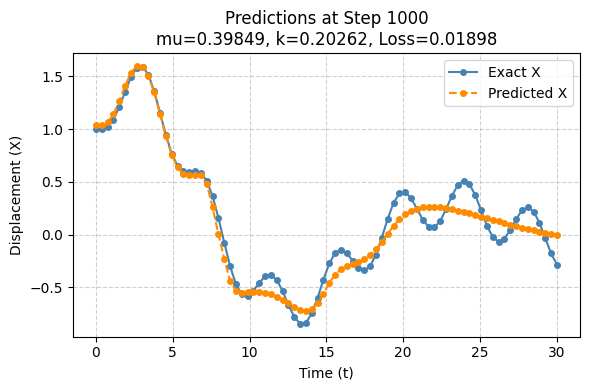

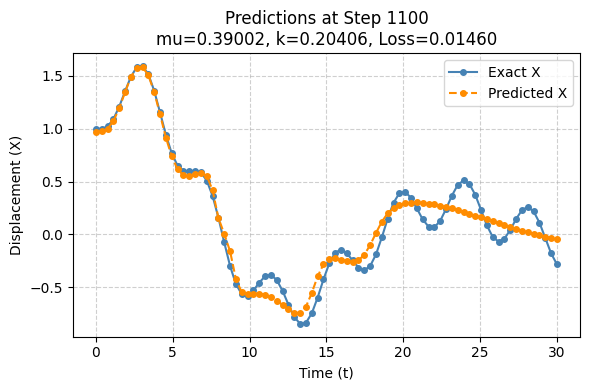

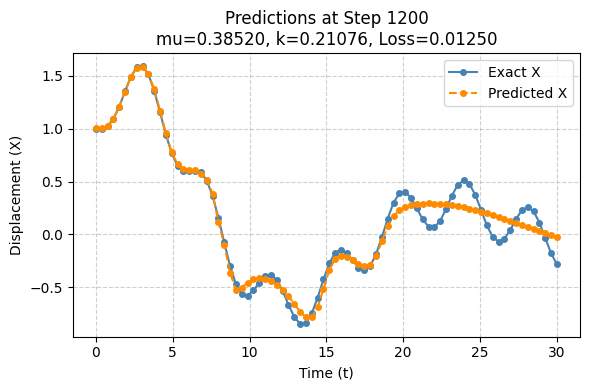

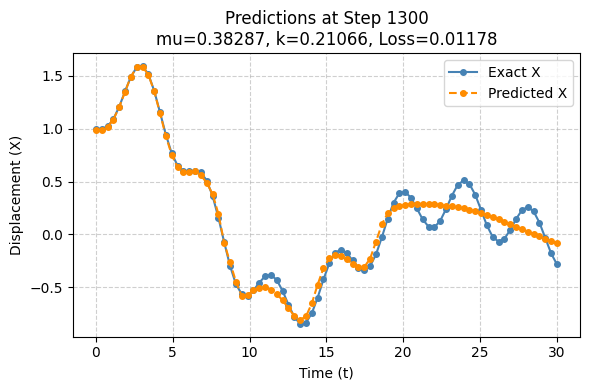

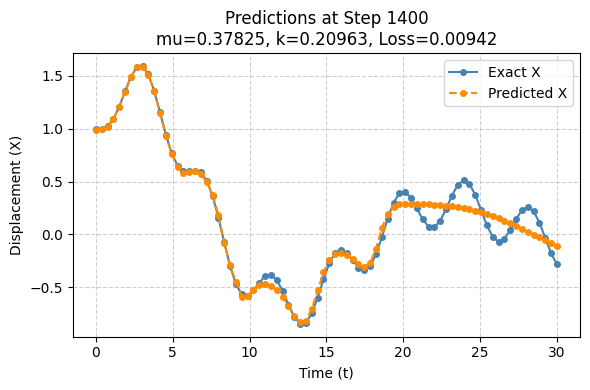

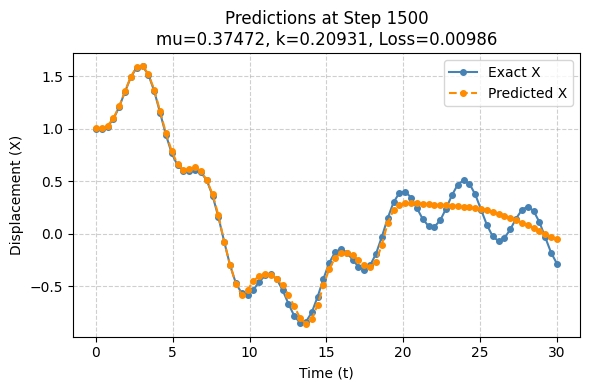

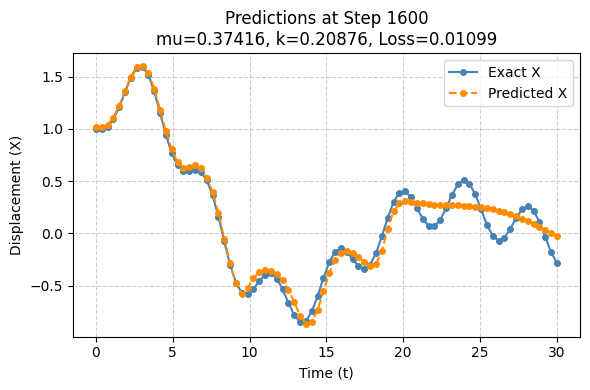

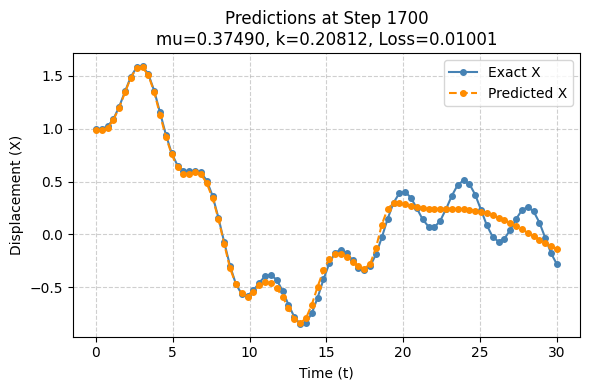

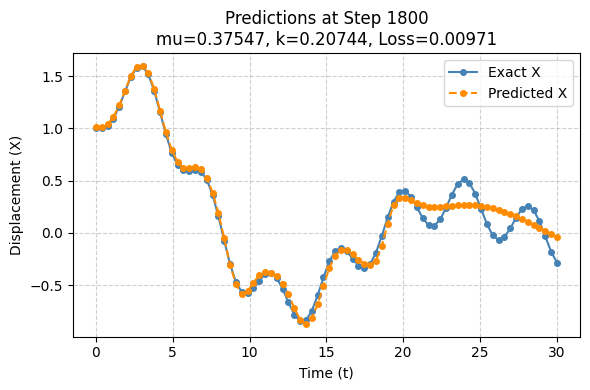

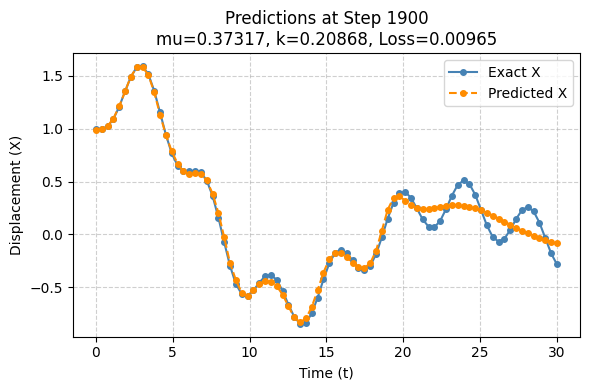

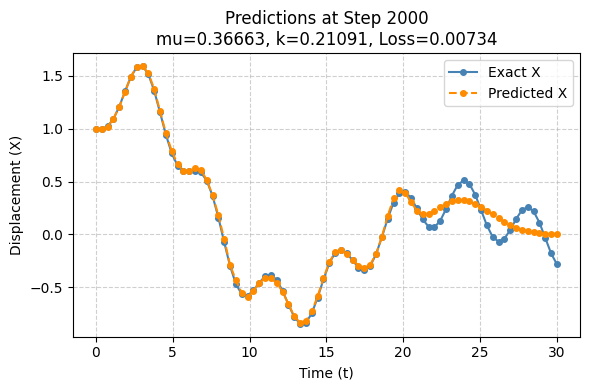

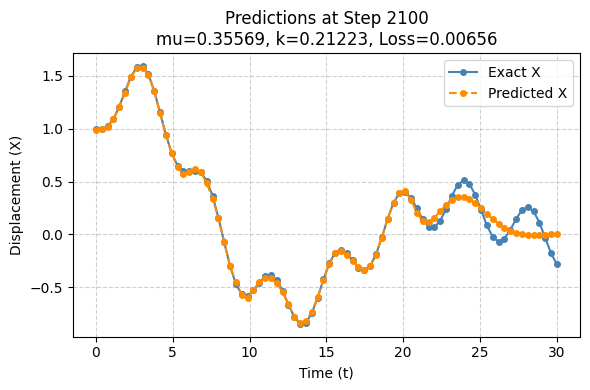

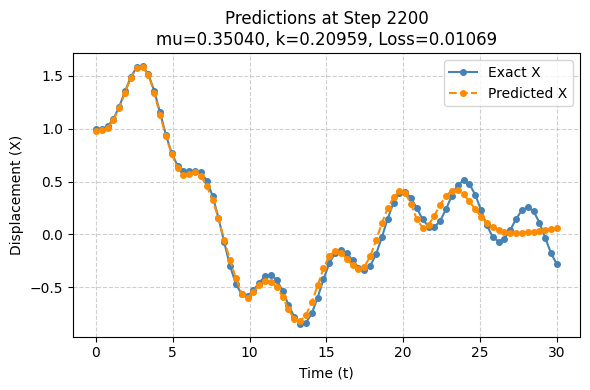

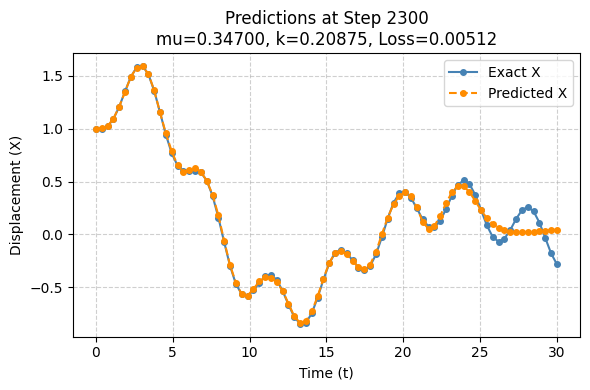

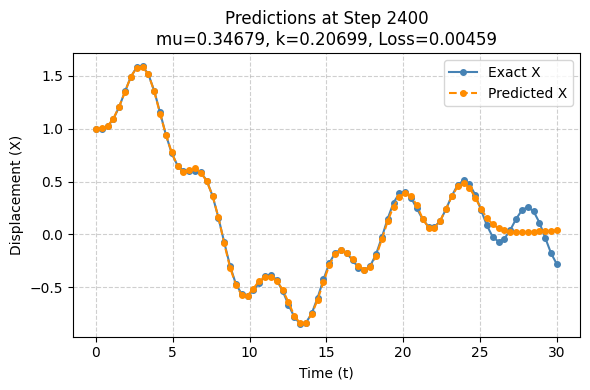

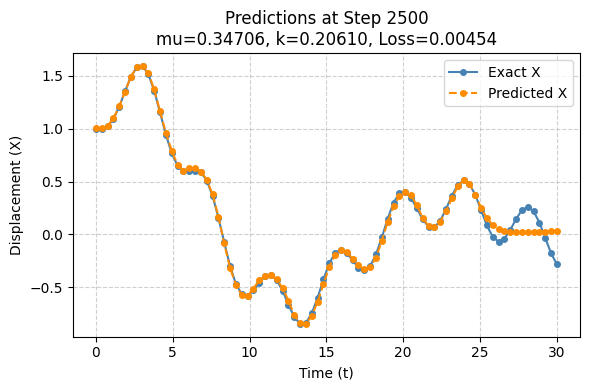

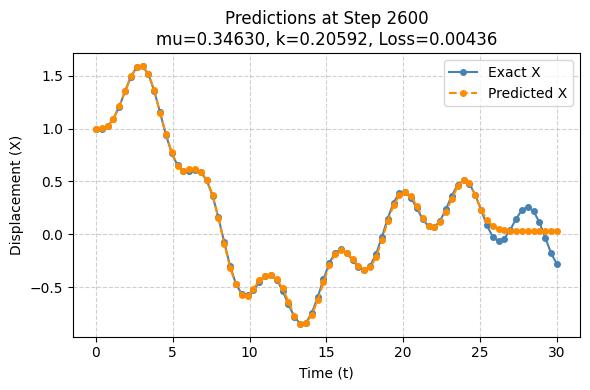

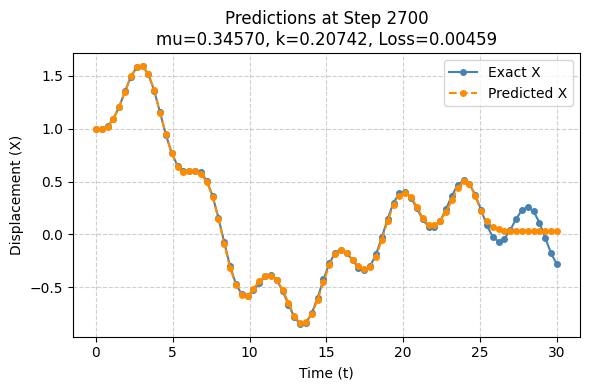

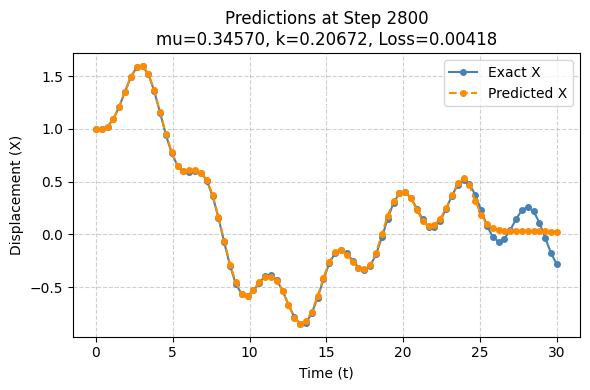

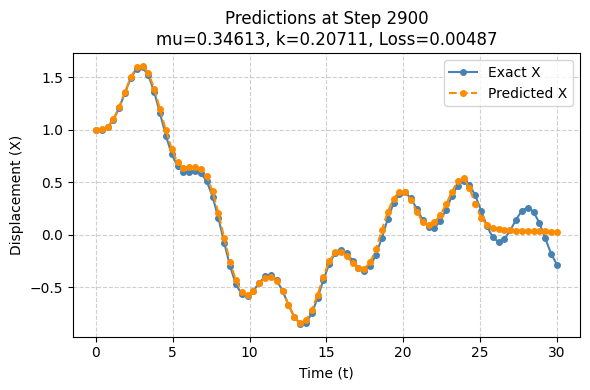

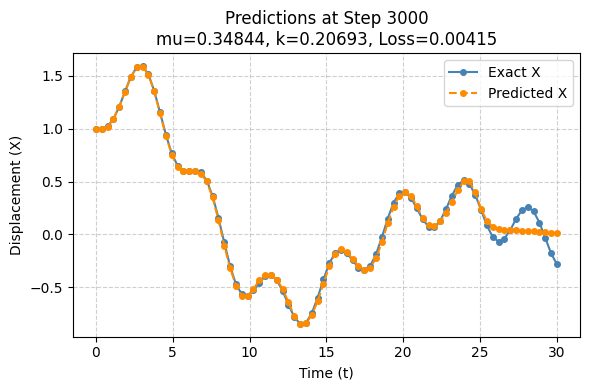

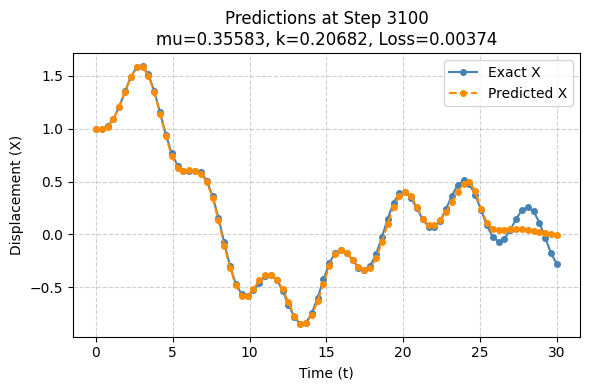

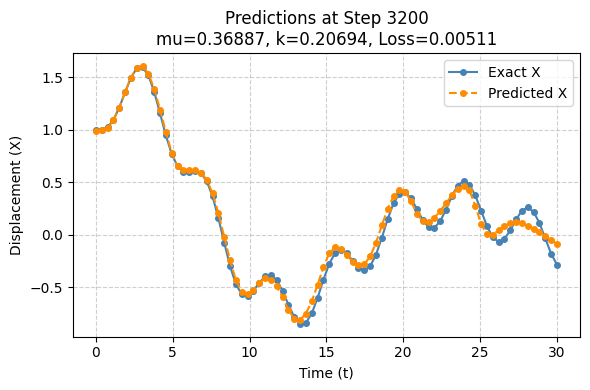

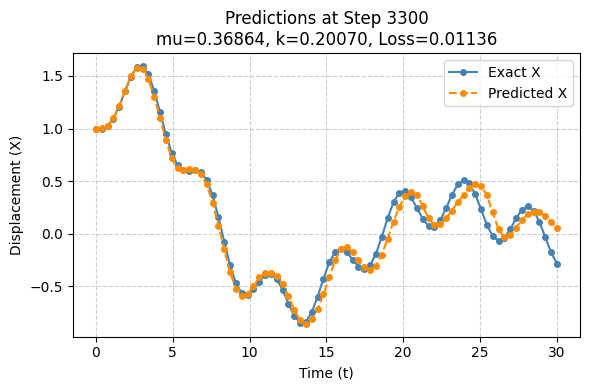

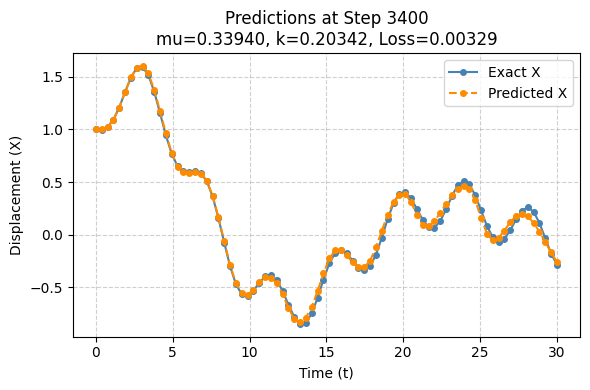

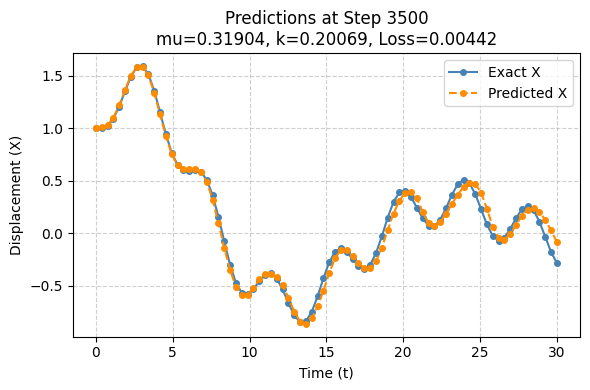

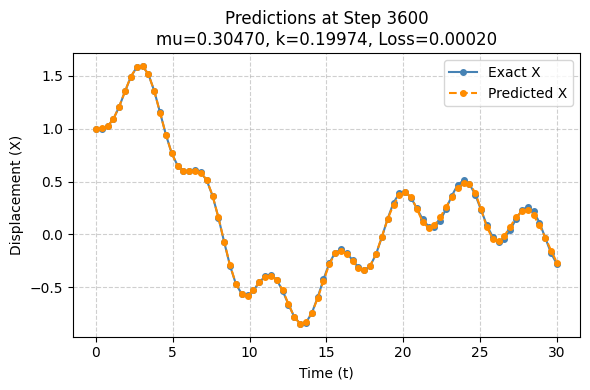

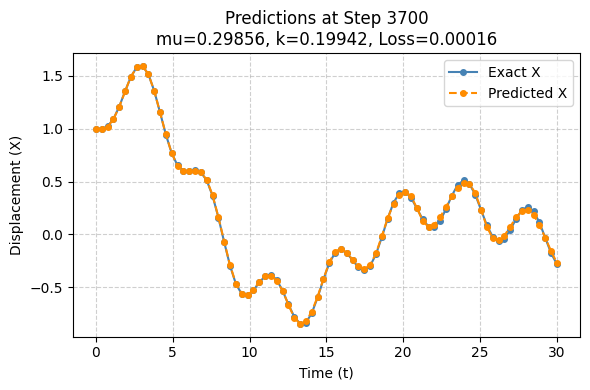

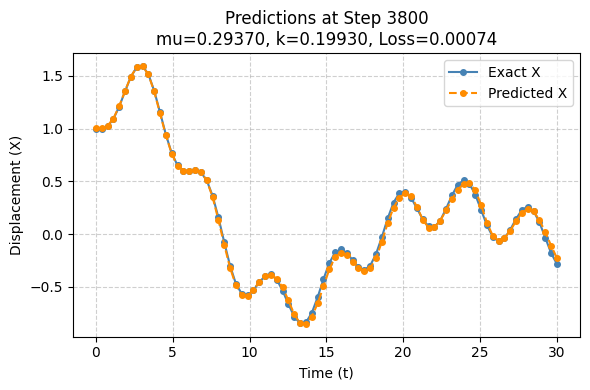

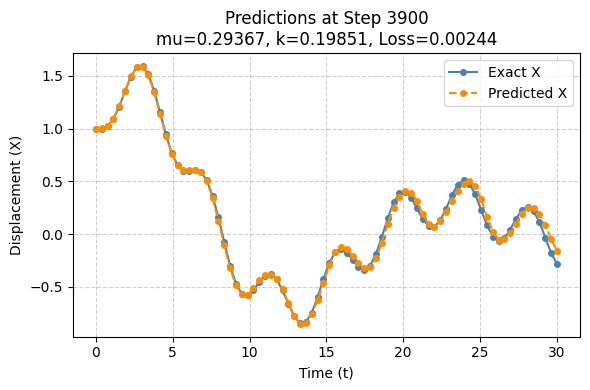

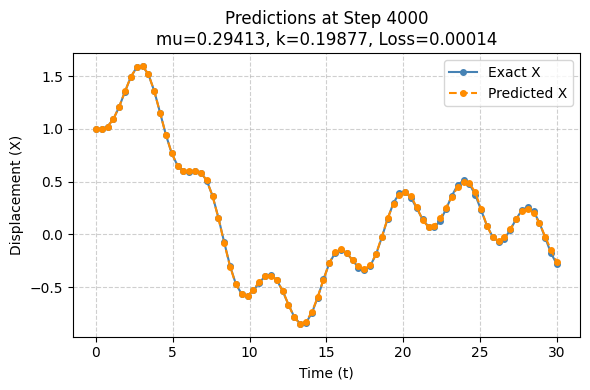

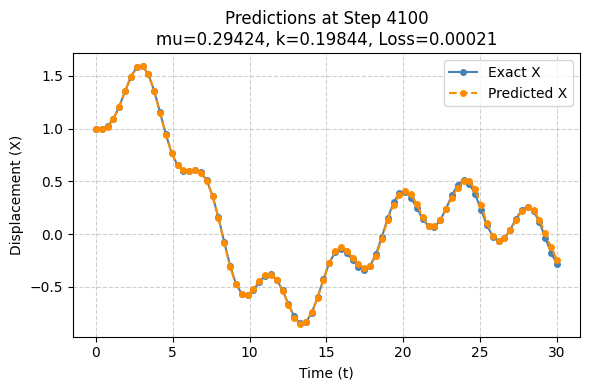

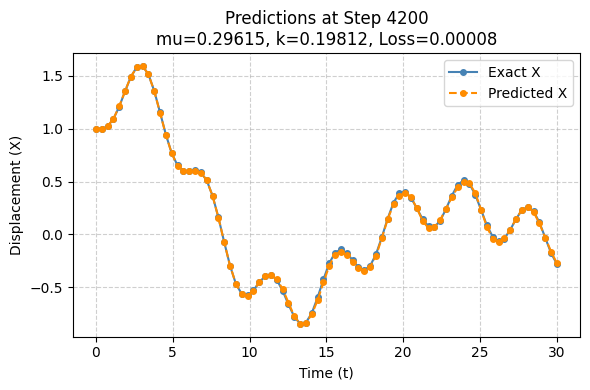

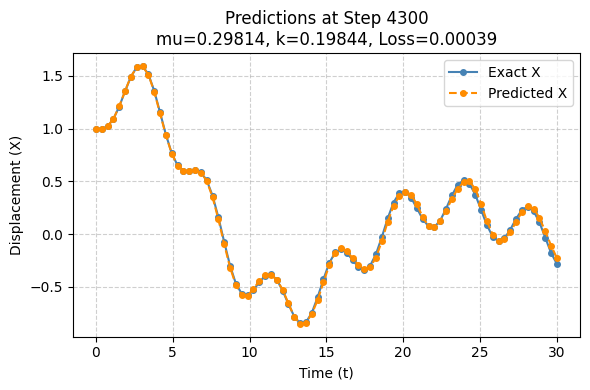

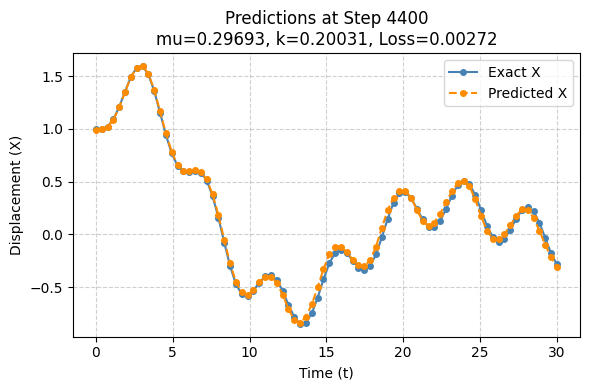

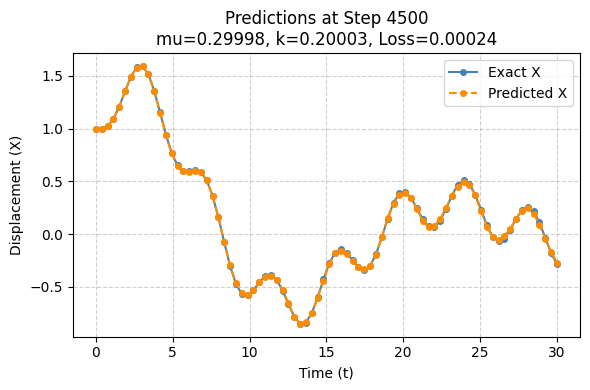

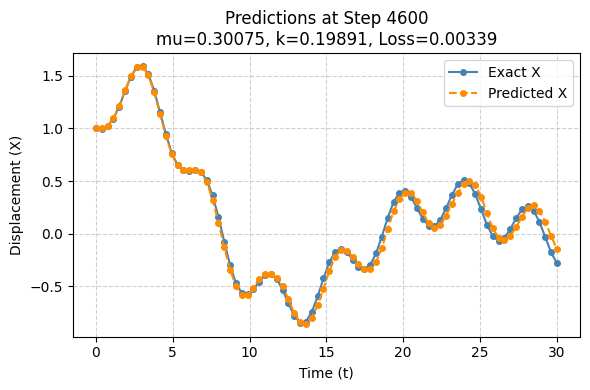

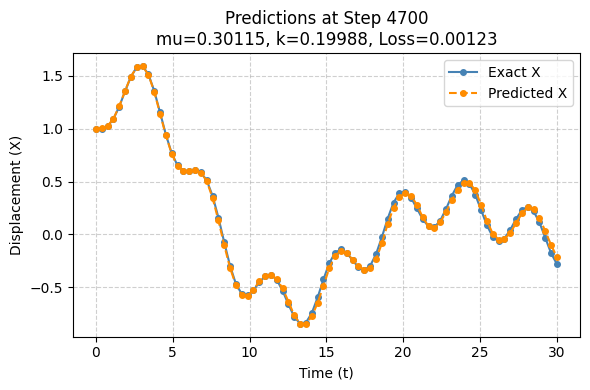

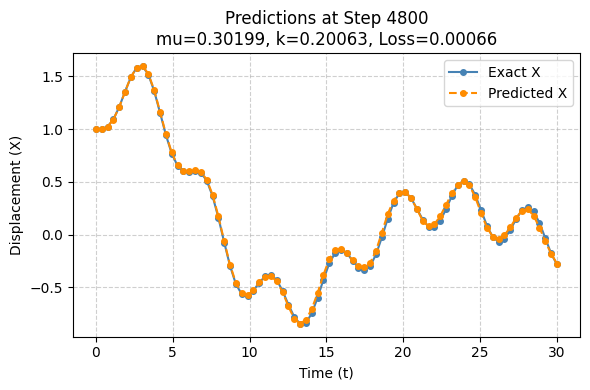

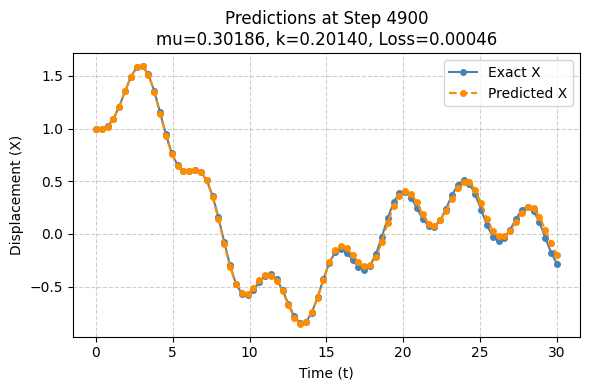

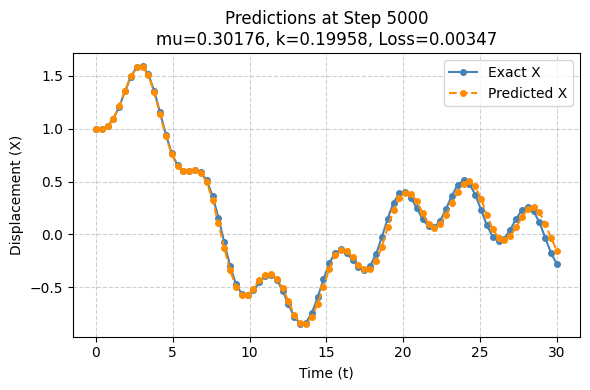

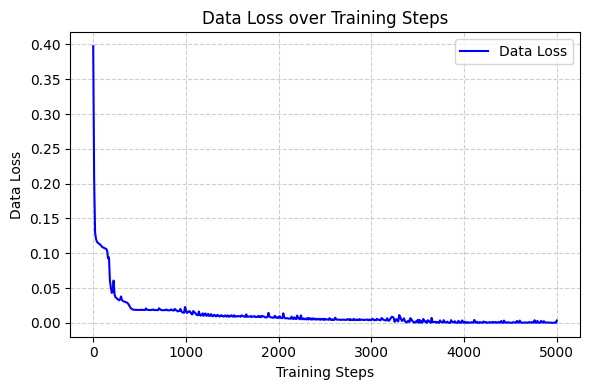

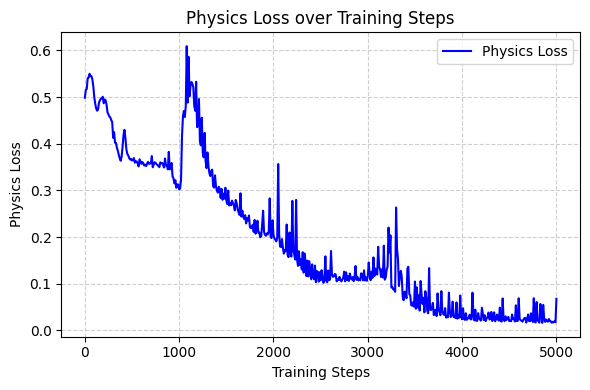

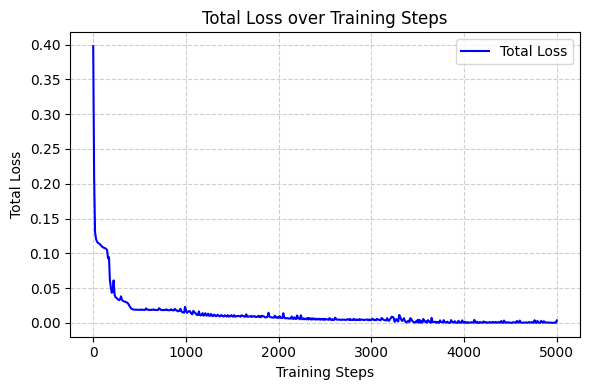

🏆 Final Estimates: mu=0.30176, k=0.19958, Fixed Parameters: m=2.0, A=1.0, omega=1.5


In [19]:
# === Final Training with Best Parameters ===
print("📈 Training final model with best parameters and plotting results...")
_, estimated_values = pinn_training(t, x, fixed_params, **best_params, epochs=5000, plot=True)

# === Final Output ===
estimated_params_str = ", ".join([f"{key}={val:.5f}" for key, val in estimated_values.items()])
fixed_params_str = ", ".join([f"{key}={val}" for key, val in fixed_params.items()])
print(f"🏆 Final Estimates: {estimated_params_str}, Fixed Parameters: {fixed_params_str}")

## Inverse Solution in range and outside range testing

Initial Conditions: X0 = 1.0000, V0 = 0.0000


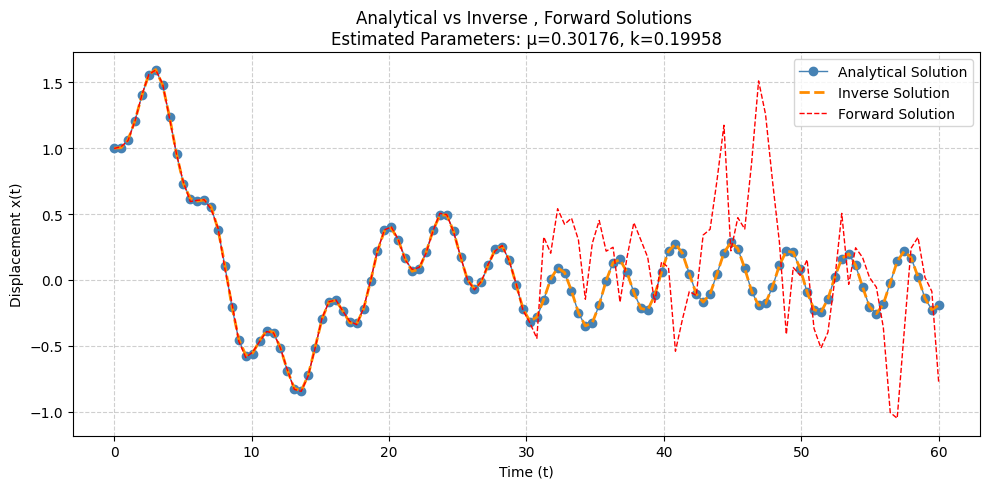

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define forced oscillator system
def forced_damped_oscillator(t, y, m, mu, k, A, omega):
    x, v = y
    dxdt = v
    dvdt = (1/m) * (A * np.sin(omega * t) - mu * v - k * x)
    return [dxdt, dvdt]

# Prediction function
def predict_x_values_nonhomogeneous(m, mu, k, A, omega, test_t, x0, v0):
    if len(test_t) == 0:
        raise ValueError("Test time vector is empty.")
    t_span = (test_t[0], test_t[-1])
    solution = solve_ivp(
        forced_damped_oscillator,
        t_span,
        [x0, v0],
        args=(m, mu, k, A, omega),
        t_eval=test_t,
        method='RK45'
    )
    return solution.y[0]

# === Load test data ===
test_t = test_df['Time'].values
x0 = test_df['Displacement'].iloc[0]
v0 = test_df['Velocity'].iloc[0]
print(f"Initial Conditions: X0 = {x0:.4f}, V0 = {v0:.4f}")

# === Use your estimated parameters ===
m_estimate = 2.0  # fixed
A_fixed = 1.0     # fixed
mu_estimate = 0.30176
k_estimate = 0.19958
omega_estimate = 1.5

# Predict trajectory
predicted_x = predict_x_values_nonhomogeneous(
    m=m_estimate,
    mu=mu_estimate,
    k=k_estimate,
    A=A_fixed,
    omega=omega_estimate,
    test_t=test_t,
    x0=x0,
    v0=v0
)


test_df['Predicted_Displacement'] = predicted_x

# === Plot: Actual vs Predicted Displacement ===
plt.figure(figsize=(10, 5))
plt.plot(test_df['Time'], test_df['Displacement'],"o-", label="Analytical Solution", color="steelblue", linewidth=1)
plt.plot(test_df['Time'], test_df['Predicted_Displacement'], label="Inverse Solution", color="darkorange", linestyle='--', linewidth=2)
plt.plot(test_df['Time'], test_df['PINN_Solution_Predicted_Displacement'], label="Forward Solution", color="red", linestyle='--', linewidth=1)
plt.xlabel("Time (t)")
plt.ylabel("Displacement x(t)")
plt.title("Analytical vs Inverse , Forward Solutions \nEstimated Parameters: μ={:.5f}, k={:.5f}".format(mu_estimate, k_estimate))
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [24]:
# Function to calculate RMSE
def calculate_rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted) ** 2))

# Compute RMSE for both predicted and model-predicted values
rmse_predicted = calculate_rmse(test_df['Displacement'], test_df['PINN_Solution_Predicted_Displacement'])
rmse_model_inverse = calculate_rmse(test_df['Displacement'], test_df['Predicted_Displacement'])

print(f"RMSE for Forward Solution: {rmse_predicted:.5f}")
print(f"RMSE for Inverse Solution: {rmse_model_inverse:.6f}")


RMSE for Forward Solution: 0.37461
RMSE for Inverse Solution: 0.002362
